In [1]:
import numpy as np
import torch.optim as opt
from torch import nn
import torch
from math import log
import matplotlib.pyplot as plt
import torch.nn.functional as F
import plotly.graph_objects as go

## Warmup

In [2]:
def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [3]:
data = np.array([i - 1 for i in sample_data()])

In [4]:
print(data)

[47 75 87 ... 34 29 42]


In [5]:
class Model(nn.Module):
    def __init__(self, size):
        super(Model, self).__init__()
        self.theta = nn.Parameter(torch.zeros(size, requires_grad=True, dtype=torch.float))
        
    def forward(self, batch):
        exp_theta = torch.exp(self.theta)
        result = -((exp_theta / exp_theta.sum()).log())[batch].sum() / len(batch)
        return result

In [6]:
train, validate, test = data[:int(0.6 * data.size)], data[int(0.6 * data.size):int(0.8 * data.size)], data[int(0.8 * data.size):] 

In [7]:
lr = 1e-1
n_epochs = 2000
model = Model(100)

optimizer = opt.SGD(model.parameters(), lr=lr)

train_losses = []
validate_losses = []

for epoch in range(n_epochs):
    batch = np.random.choice(train, size=300)
    error = model.forward(batch)
    
    train_losses.append(error)
    validate_losses.append(model.forward(validate))
    
    #print(model.forward(validate))
    error.backward()   
    optimizer.step()
    optimizer.zero_grad()

Likelihood by iteration.


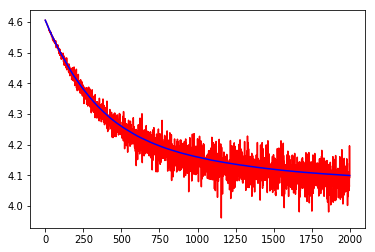

In [8]:
print("Likelihood by iteration.")
plt.plot(range(0, len(train_losses)), train_losses, 'r',
         range(0, len(validate_losses)), validate_losses, 'b')

In [9]:
print("Result on test (negative log likelyhood): ", float(model.forward(test)))

Result on test (negative log likelyhood):  4.084925174713135


<BarContainer object of 100 artists>

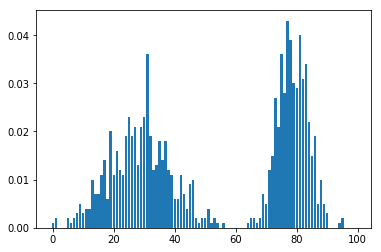

In [10]:
def count_freqs(batch, size):
    result = np.zeros(size)
    for x in batch:
        result[x] += 1
    return result

sample = np.random.choice(data, size=1000)

plt.bar(np.arange(100), count_freqs(sample, 100) / 1000)

<BarContainer object of 100 artists>

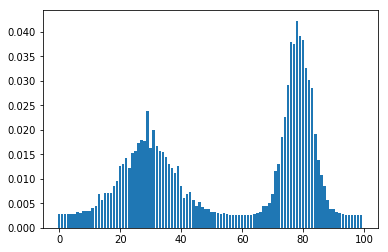

In [11]:
plt.bar(np.arange(100), (torch.exp(model.theta) / torch.exp(model.theta).sum()).detach().numpy())

## Two-dimensional data

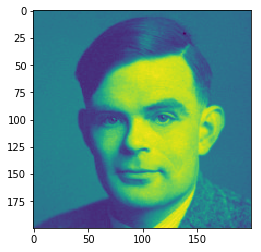

In [13]:
pic = np.load('distribution.npy')
plt.imshow(pic)

In [62]:
data_size = 100000
data = [(i // pic.shape[1], i % pic.shape[1]) for i in np.random.choice(np.arange(pic.size), p=pic.reshape(-1), size=data_size)]

In [63]:
train, validate, test = data[:int(data_size * 0.6)], data[int(data_size * 0.6):int(data_size * 0.8)], data[int(data_size * 0.8):]

In [64]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.theta_model = Model(input_size)
        
        self.input_size = input_size
        self.num_classes = num_classes
        
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, batch):
        xs_batch = batch[:, 0]
        ys_batch = batch[:, 1]
        
        xs_matrix = xs_batch[:, None] == np.arange(self.input_size)
        
        matrix = torch.tensor(xs_matrix).float()
        
        out = self.fc1(matrix)
        out = self.relu(out)
        out = self.fc2(out)
        out = F.softmax(out, dim=1)
        
        xs_error = self.theta_model.forward(xs_batch)
        ys_error = -torch.gather(out, 1, torch.tensor(ys_batch[:, None])).log().sum() / ys_batch.size
        return xs_error + ys_error

In [91]:
n_epochs = 1000
model = MLP(200, 200, 200)

lr = 1e-2

optimizer = opt.Adam(model.parameters(), lr=lr, betas=(0.99, 0.999))

train_losses = []
validate_losses = []

nodes = np.arange(len(train))
validate = np.array(validate)

for epoch in range(n_epochs):
    batch = np.array([train[i] for i in np.random.choice(nodes, size=1000)])
    
    error = model.forward(batch)
    
    train_losses.append(float(error))
    validate_losses.append(float(model.forward(validate)))
    
    print("\rEpoch {}/{}. Losses: train: {}, validate: {}"
          .format(epoch, n_epochs, train_losses[-1], validate_losses[-1]), end="")
    
    error.backward()   
    optimizer.step()
    optimizer.zero_grad()

Epoch 999/1000. Losses: train: 10.280815124511719, validate: 10.828906059265137

Likelihood by iteration.


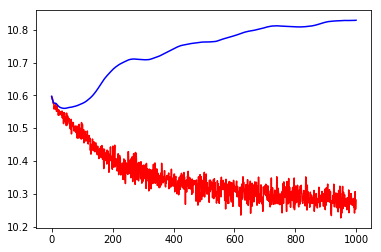

In [92]:
print("Likelihood by iteration.")
plt.plot(range(0, len(train_losses)), train_losses, 'r',
         range(0, len(validate_losses)), validate_losses, 'b')

In [93]:
print("Result on test (negative log likelyhood): ", float(model.forward(np.array(test))))

Result on test (negative log likelyhood):  10.830045700073242


In [94]:
predicted_pic = np.array([[float(torch.exp(-model.forward(np.array([(i, j)])))) for j in range(200)] for i in range(200)])

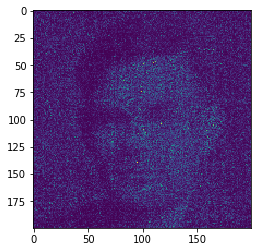

In [95]:
plt.imshow(predicted_pic / predicted_pic.sum())

In [112]:
class MaskedLinear(torch.nn.Linear):
    def __init__(self, inp, outp, mask, bias=True):
        super().__init__(inp, outp, bias)        
        self.mask = mask
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

In [121]:
class MADE(torch.nn.Module):
    def __init__(self, size=400, hidden_layers=1):
        super().__init__()
        
        self.size = size
        
        ms = [np.random.permutation(size)]
        for _ in range(hidden_layers + 1):
            ms.append(np.random.randint(ms[-1].min(), size, size=size))
            
        masks = []
        for m, next_m in zip(ms, ms[1:]):
            masks.append(torch.tensor((m[:,None] <= next_m[None,:])).float())
        masks.append(torch.tensor((ms[-1][:,None] < ms[0][None,:])).float())
            
        layers = []
            
        for mask in masks:
            layers.append(MaskedLinear(size, size, mask))
            layers.append(nn.ReLU())
        layers.pop()
            
        self.model = nn.Sequential(*layers)

    def forward(self, batch):
        xs_batch = batch[:, 0]
        ys_batch = batch[:, 1]
        
        xs_matrix = xs_batch[:, None] == np.arange(self.size / 2)
        ys_matrix = ys_batch[:, None] == np.arange(self.size / 2)
        
        matrix = torch.tensor(np.concatenate((xs_matrix, ys_matrix), 1)).float()
       
        out = self.model(matrix)
        out = out.view(-1, 2, 200)
        out = F.softmax(out, dim=2).view(-1, 400)
        
        return -torch.gather(out, 1, torch.tensor(batch)).log().sum() / batch.size

In [122]:
n_epochs = 1000
model = MADE(400, 1)


lr = 1e-2

optimizer = opt.Adam(model.parameters(), lr=lr, weight_decay=0.0025)

train_losses = []
validate_losses = []
predicted_pic = []

nodes = np.arange(len(train))
validate = np.array(validate)

for epoch in range(n_epochs + 1):
    batch = np.array([train[i] for i in np.random.choice(nodes, size=100)])
    
    error = model.forward(batch)
    
    train_losses.append(float(error))
    validate_losses.append(float(model.forward(validate)))
    
    if epoch and not epoch % 200:
        predicted_pic.append(np.array(
            [[float(torch.exp(-model.forward(np.array([(i, j)])))) for j in range(200)] for i in range(200)]))
    
    print("\rEpoch {}/{}. Losses: train: {}, validate: {}"
          .format(epoch, n_epochs, train_losses[-1], validate_losses[-1]), end="")
    
    error.backward()   
    optimizer.step()
    optimizer.zero_grad()

Epoch 1000/1000. Losses: train: 1.645448923110962, validate: 1.6811538934707642

Likelihood by iteration.


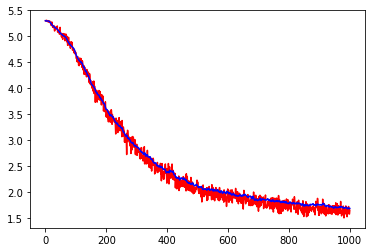

In [123]:
print("Likelihood by iteration.")
plt.plot(range(0, len(train_losses)), train_losses, 'r',
         range(0, len(validate_losses)), validate_losses, 'b')

In [124]:
print("Result on test (negative log likelyhood): ", float(model.forward(np.array(test))))

Result on test (negative log likelyhood):  1.6826229095458984


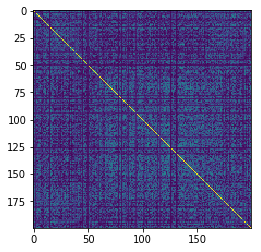

In [125]:
i = -3

plt.imshow(predicted_pic[i] / predicted_pic[i].sum())